<a href="https://colab.research.google.com/github/MariiaZimokha/notebooks/blob/main/kaggle/scene_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Data


In [ ]:
file_path = "/content/drive/MyDrive/Studying/image classification.zip"
# file_path = "/content/drive/MyDrive/image classification.zip"
output_path = "/tmp/image_classification"

from zipfile import ZipFile

with ZipFile(file_path, 'r') as zip_ref:
  zip_ref.extractall(output_path)

## Imports

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

In [ ]:
tf.__version__


'2.7.0'

## Data exploration 

In [ ]:
# image size 150x150
def plot_img(dir):
  row_num = 4
  col_num = 4

  pics_names = os.listdir(dir)

  fig = plt.gcf()
  fig.set_size_inches(15, 20)

  pic_index = 8
  next_pic = [os.path.join(dir, fname) 
                  for fname in pics_names[pic_index-8:pic_index]]


  for i,img_path in enumerate(next_pic):
    sp = plt.subplot(row_num, col_num, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

In [ ]:
def plot_metrics(metric, val_metrics, epochs, name):
  plt.plot(epochs, metric, 'r', label=f'Training {name}')
  plt.plot(epochs, val_metrics, 'b', label=f'Validation {name}')
  plt.title(f'Training and validation {name}')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

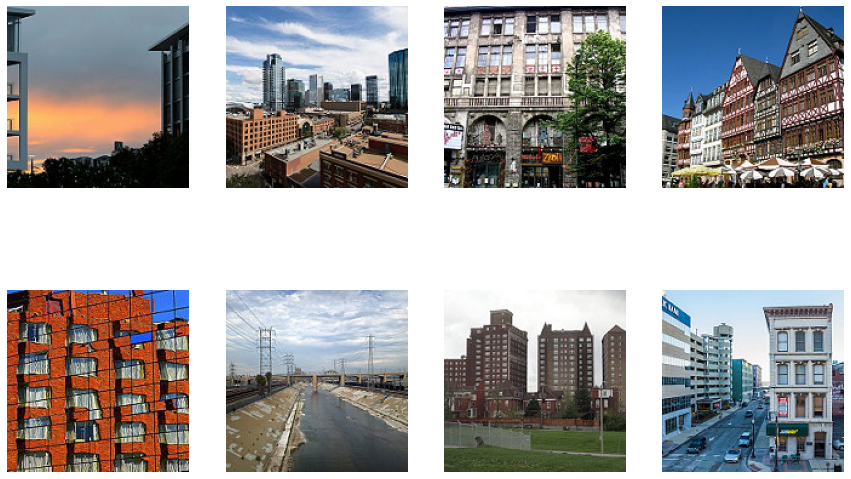

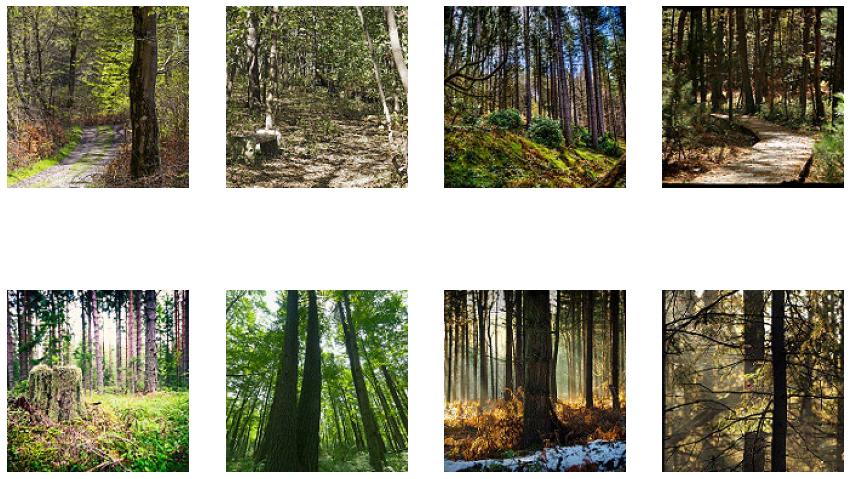

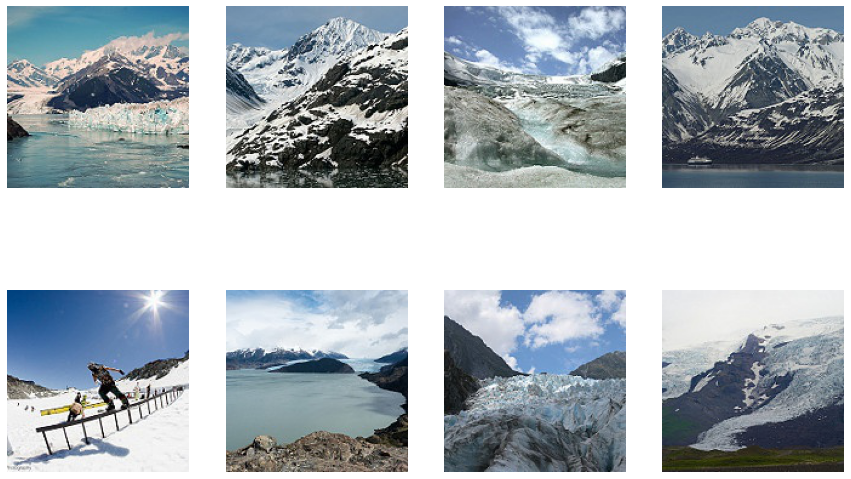

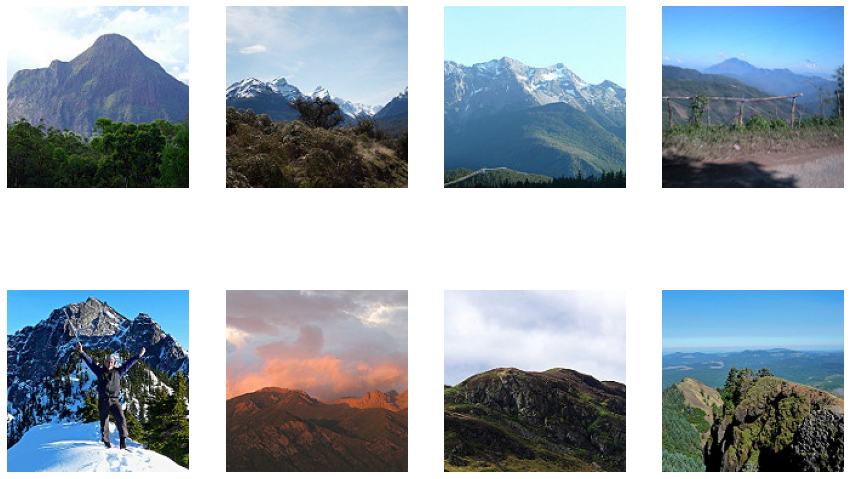

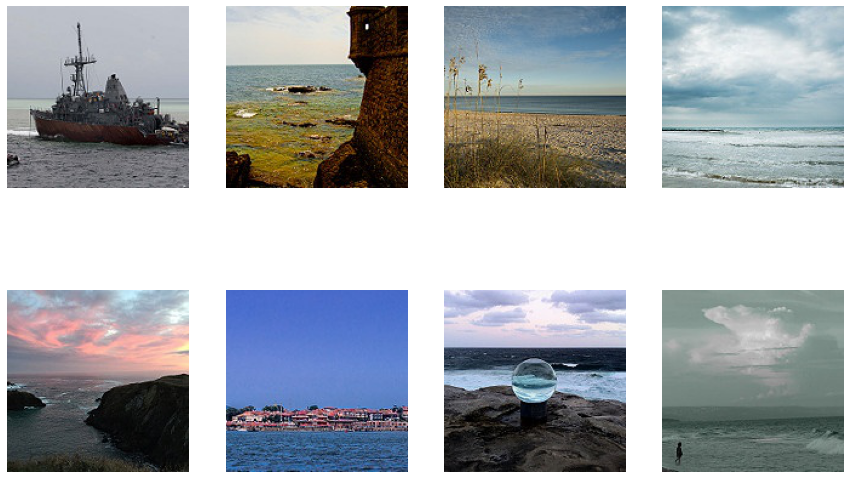

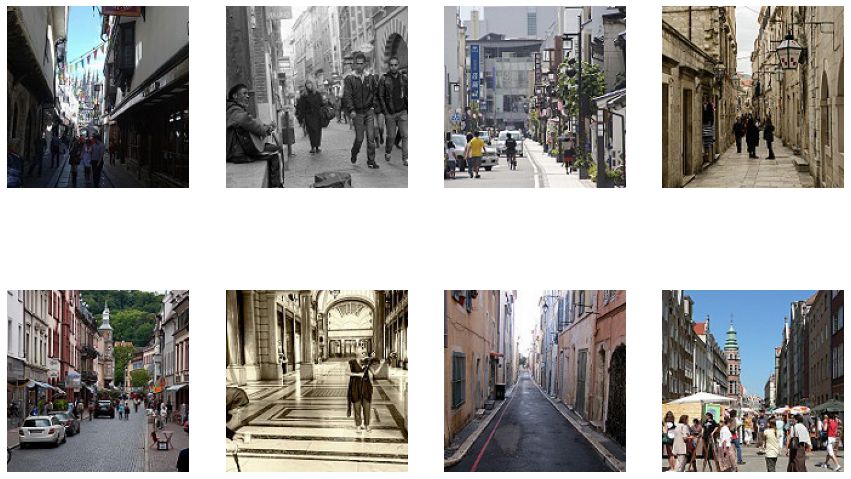

In [ ]:
train_dir = "/tmp/image_classification/seg_train/seg_train"
test_dir = "/tmp/image_classification/seg_test/seg_test"

labels = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

for label in labels:
  plot_img(f"{train_dir}/{label}")


In [ ]:
from PIL import Image

size_set = set()

for label in labels:
  dir = f"{train_dir}/{label}"
  
  pics_names = os.listdir(dir)
  
  for pic in pics_names:
    im = Image.open(os.path.join(dir, pic))
    width, height = im.size
    size_set.add((width, height))

print(size_set)

{(150, 141), (150, 123), (150, 81), (150, 110), (150, 147), (150, 103), (150, 134), (150, 124), (150, 120), (150, 76), (150, 113), (150, 111), (150, 144), (150, 142), (150, 100), (150, 135), (150, 149), (150, 131), (150, 108), (150, 145), (150, 143), (150, 97), (150, 119), (150, 150), (150, 140), (150, 133), (150, 115), (150, 105), (150, 146), (150, 136), (150, 102)}


In [ ]:
# os.listdir() 
# train_dir
# labels

for label in labels:
  folder_path = f"{train_dir}/{label}"
  print(f"{label}: {len(os.listdir(folder_path))}")

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


## Image preprocessing 

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=20,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=20,
    class_mode="categorical"
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
next(iter(train_generator))[0].shape

(20, 150, 150, 3)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np


all_pred_data = os.listdir("/tmp/image_classification/seg_pred/seg_pred")

pred_path = "/tmp/image_classification/seg_pred/seg_pred"

# PIL.Image.open(f"{pred_path}/{all_pred_data[32]}")

img = image.load_img(f"{pred_path}/{all_pred_data[32]}", target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
test_me_generator = train_datagen.flow_from_directory(
    "/tmp/image_classification/test-me/",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical"
)

Found 1 images belonging to 2 classes.


In [ ]:
next(iter(test_me_generator))[0].shape

(1, 150, 150, 3)

In [ ]:
type(x)

numpy.ndarray

## Model


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(6, activation="softmax")
])

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
history = model.fit(
    train_generator,
    # batch_size=
    epochs=5,
    validation_data=test_generator,
    verbose=2
)

Epoch 1/5
702/702 - 28s - loss: 0.5449 - accuracy: 0.8060 - val_loss: 0.5257 - val_accuracy: 0.8077 - 28s/epoch - 40ms/step
Epoch 2/5
702/702 - 28s - loss: 0.4446 - accuracy: 0.8418 - val_loss: 0.4626 - val_accuracy: 0.8367 - 28s/epoch - 40ms/step
Epoch 3/5
702/702 - 28s - loss: 0.3887 - accuracy: 0.8618 - val_loss: 0.4869 - val_accuracy: 0.8300 - 28s/epoch - 40ms/step
Epoch 4/5
702/702 - 28s - loss: 0.3073 - accuracy: 0.8888 - val_loss: 0.4912 - val_accuracy: 0.8250 - 28s/epoch - 40ms/step
Epoch 5/5
702/702 - 28s - loss: 0.2417 - accuracy: 0.9139 - val_loss: 0.5641 - val_accuracy: 0.8187 - 28s/epoch - 40ms/step


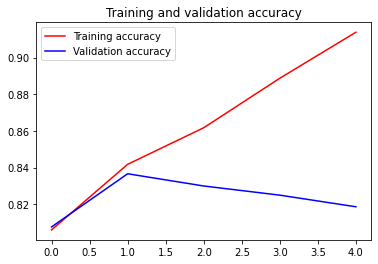

<Figure size 432x288 with 0 Axes>

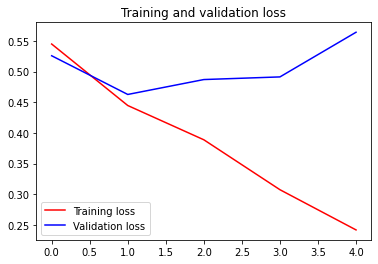

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plot_metrics(acc, val_acc, epochs, "accuracy")
plot_metrics(loss, val_loss, epochs, "loss")

## Model with Dropout

In [ ]:
model_dropout = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(6, activation="softmax")
])

In [ ]:
model_dropout.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history_with_dropout = model_dropout.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    verbose=2
)

Epoch 1/5
702/702 - 35s - loss: 0.0830 - accuracy: 0.9721 - val_loss: 0.8549 - val_accuracy: 0.8400 - 35s/epoch - 50ms/step
Epoch 2/5
702/702 - 35s - loss: 0.0857 - accuracy: 0.9736 - val_loss: 0.8435 - val_accuracy: 0.8560 - 35s/epoch - 50ms/step
Epoch 3/5
702/702 - 35s - loss: 0.0876 - accuracy: 0.9721 - val_loss: 0.7700 - val_accuracy: 0.8433 - 35s/epoch - 50ms/step
Epoch 4/5
702/702 - 35s - loss: 0.0759 - accuracy: 0.9760 - val_loss: 0.7904 - val_accuracy: 0.8417 - 35s/epoch - 50ms/step
Epoch 5/5
702/702 - 35s - loss: 0.0769 - accuracy: 0.9753 - val_loss: 0.8365 - val_accuracy: 0.8367 - 35s/epoch - 50ms/step


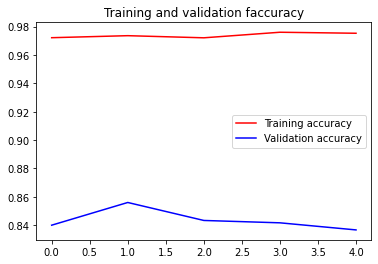

<Figure size 432x288 with 0 Axes>

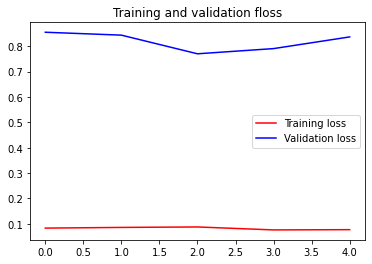

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history_with_dropout.history['accuracy']
val_acc = history_with_dropout.history['val_accuracy']
loss = history_with_dropout.history['loss']
val_loss = history_with_dropout.history['val_loss']

epochs = range(len(acc))
plot_metrics(acc, val_acc, epochs, "accuracy")
plot_metrics(loss, val_loss, epochs, "loss")

In [ ]:
img_path = "/tmp/image_classification/seg_pred/seg_pred/10013.jpg"

img = tf.keras.utils.load_img(
    img_path, target_size=(150, 150)
)
img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_dropout.predict(img_array)
print(model_dropout)

NameError: ignored

## data augmentation in grayscale

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    color_mode="grayscale",
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    color_mode="grayscale",
    class_mode="categorical"
)

In [ ]:
model_aug = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(150, 150, 1)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(6, activation="softmax")
])

In [ ]:
model_aug.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history_aug = model_aug.fit(
    train_generator,
    epochs=35,
    validation_data=test_generator,
    verbose=2
)

In [ ]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs = range(len(acc))
plot_metrics(acc, val_acc, epochs, "accuracy")
plot_metrics(loss, val_loss, epochs, "loss")


## Data augmentation in RGB - base model

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode="categorical"
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
class_names = train_generator.class_indices
print(class_names)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


### Visualising data from generator

(32, 150, 150, 3)


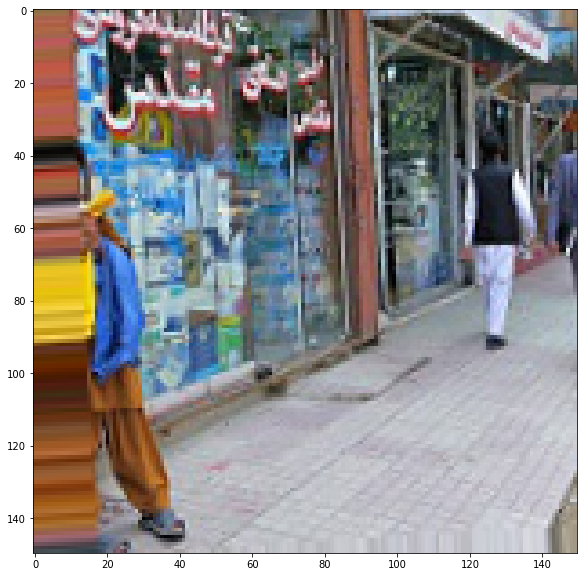

(32, 150, 150, 3)


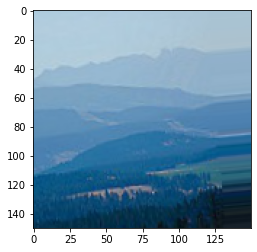

(32, 150, 150, 3)


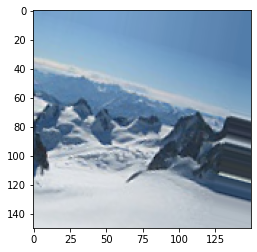

(32, 150, 150, 3)


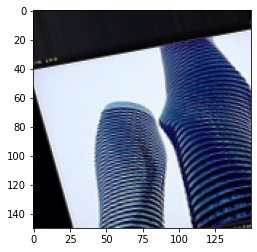

(32, 150, 150, 3)


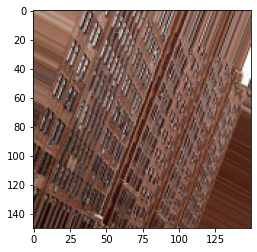

In [ ]:
plt.figure(figsize=(10, 10))
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


In [ ]:
model_aug_rgb = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(6, activation="softmax")
])

In [ ]:
model_aug_rgb.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history_aug_rgb = model_aug_rgb.fit(
    train_generator,
    epochs=35,
    validation_data=test_generator,
    verbose=2
)

Epoch 1/35
439/439 - 101s - loss: 1.1903 - accuracy: 0.5195 - val_loss: 0.9574 - val_accuracy: 0.6317 - 101s/epoch - 230ms/step
Epoch 2/35
439/439 - 99s - loss: 0.9871 - accuracy: 0.6156 - val_loss: 0.7859 - val_accuracy: 0.7023 - 99s/epoch - 226ms/step
Epoch 3/35
439/439 - 100s - loss: 0.8721 - accuracy: 0.6707 - val_loss: 0.6615 - val_accuracy: 0.7570 - 100s/epoch - 227ms/step
Epoch 4/35
439/439 - 98s - loss: 0.8056 - accuracy: 0.6992 - val_loss: 0.7405 - val_accuracy: 0.7200 - 98s/epoch - 222ms/step
Epoch 5/35
439/439 - 100s - loss: 0.7637 - accuracy: 0.7185 - val_loss: 0.6111 - val_accuracy: 0.7877 - 100s/epoch - 227ms/step
Epoch 6/35
439/439 - 102s - loss: 0.7114 - accuracy: 0.7405 - val_loss: 0.5903 - val_accuracy: 0.7923 - 102s/epoch - 232ms/step
Epoch 7/35
439/439 - 100s - loss: 0.6859 - accuracy: 0.7520 - val_loss: 0.6300 - val_accuracy: 0.7567 - 100s/epoch - 228ms/step
Epoch 8/35
439/439 - 99s - loss: 0.6684 - accuracy: 0.7553 - val_loss: 0.5525 - val_accuracy: 0.8070 - 99s/e

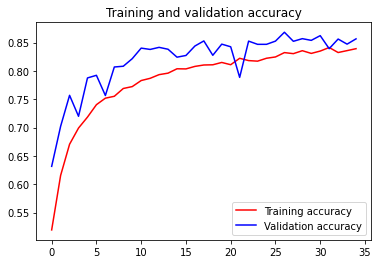

<Figure size 432x288 with 0 Axes>

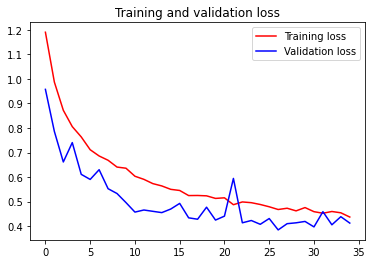

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history_aug_rgb.history['accuracy']
val_acc = history_aug_rgb.history['val_accuracy']
loss = history_aug_rgb.history['loss']
val_loss = history_aug_rgb.history['val_loss']

epochs = range(len(acc))
plot_metrics(acc, val_acc, epochs, "accuracy")
plot_metrics(loss, val_loss, epochs, "loss")

### Test prediction


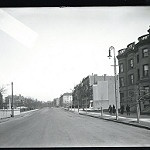

In [ ]:
pred_path = "/tmp/image_classification/seg_pred/seg_pred"
import PIL

all_pred_data = os.listdir("/tmp/image_classification/seg_pred/seg_pred")

PIL.Image.open(f"{pred_path}/{all_pred_data[23]}")

In [ ]:
image = f"{pred_path}/{all_pred_data[23]}"

image = PIL.Image.open(image)
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.image.resize(image, (150, 150))

# image = tf.image.rgb_to_grayscale(image)
# image = tf.image.grayscale_to_rgb(image)
image = tf.reshape(image, (1, 150, 150, 3))

# img_array = tf.keras.utils.img_to_array(image)
predictions = model_aug_rgb.predict(image)
print('predictions ', predictions)
score = tf.nn.softmax(predictions[0])
print('predictions ', np.argmax(score))


print('score ', score)
print('class_names ', class_names)
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

predictions  [[0. 0. 0. 0. 0. 1.]]
predictions  5
score  tf.Tensor([0.12956251 0.12956251 0.12956251 0.12956251 0.12956251 0.3521874 ], shape=(6,), dtype=float32)
class_names  {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


## Transfer learning

##### ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                               preprocessing_function=preprocess_input
                                                               )

test_me_dir = "/tmp/image_classification/test-me"
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode="categorical"
    # save_to_dir=test_me_dir
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode="categorical"
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


pre_trained_model = ResNet50(
    input_shape=(150, 150, 3),
    include_top=False,
    weights="imagenet",
    # input_tensor=tf.keras.Input(shape=(224, 224, 3))
)

# Make all layers in pre-trained model non-trainable except for the last block of the ResNet50
for layer in pre_trained_model.layers[:143]:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
pre_trained_model.output

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
# last_layer = pre_trained_model.get_layer("conv5_block3_out")
last_layer = pre_trained_model.layers[-1]
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 5, 5, 2048)


In [ ]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda image: tf.image.resize_with_pad(image, target_height=150, target_width=150)),
  pre_trained_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
                  # optimizer="adam",
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

# model.summary()

history = model.fit(
    train_generator,
    epochs=160,
    validation_data=test_generator,
    verbose=2)

Epoch 1/160
439/439 - 241s - loss: 2.0085 - accuracy: 0.2540 - val_loss: 1.3691 - val_accuracy: 0.4760 - 241s/epoch - 548ms/step
Epoch 2/160
439/439 - 228s - loss: 1.8246 - accuracy: 0.3086 - val_loss: 1.2114 - val_accuracy: 0.5170 - 228s/epoch - 520ms/step
Epoch 3/160
439/439 - 229s - loss: 1.7269 - accuracy: 0.3401 - val_loss: 1.1117 - val_accuracy: 0.5707 - 229s/epoch - 521ms/step
Epoch 4/160
439/439 - 229s - loss: 1.6350 - accuracy: 0.3695 - val_loss: 1.0357 - val_accuracy: 0.6110 - 229s/epoch - 521ms/step
Epoch 5/160
439/439 - 229s - loss: 1.5528 - accuracy: 0.3977 - val_loss: 1.0206 - val_accuracy: 0.5827 - 229s/epoch - 521ms/step
Epoch 6/160
439/439 - 229s - loss: 1.4936 - accuracy: 0.4171 - val_loss: 0.9451 - val_accuracy: 0.6470 - 229s/epoch - 522ms/step
Epoch 7/160
439/439 - 229s - loss: 1.4502 - accuracy: 0.4345 - val_loss: 0.9337 - val_accuracy: 0.6620 - 229s/epoch - 521ms/step
Epoch 8/160
439/439 - 229s - loss: 1.4187 - accuracy: 0.4530 - val_loss: 1.0165 - val_accuracy: 0

KeyboardInterrupt: ignored

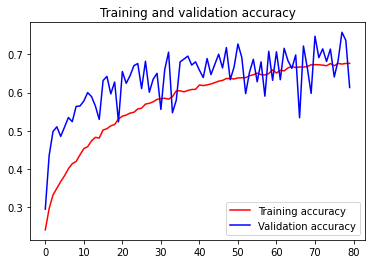

<Figure size 432x288 with 0 Axes>

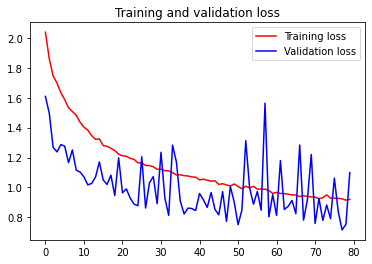

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plot_metrics(acc, val_acc, epochs, "accuracy")
plot_metrics(loss, val_loss, epochs, "loss")

In [ ]:
tf.keras.models.save_model(model, filepath="/content/drive/MyDrive/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
model.save("/content/drive/MyDrive/transfer_rs50.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


######Test prediction

In [ ]:
class_names = train_generator.class_indices
print(class_names)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:
class_names = test_generator.class_indices
print(class_names)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


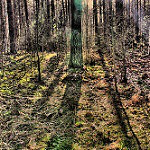

In [ ]:
pred_path = "/tmp/image_classification/seg_pred/seg_pred"
import PIL

all_pred_data = os.listdir("/tmp/image_classification/seg_pred/seg_pred")

PIL.Image.open(f"{pred_path}/{all_pred_data[40]}")

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

image_path = f"{pred_path}/{all_pred_data[40]}"

# image = PIL.Image.open(image)
# image = tf.keras.preprocessing.image.img_to_array(image)
# image = tf.image.resize(image, (150, 150))

# image = tf.image.rgb_to_grayscale(image)
# image = tf.image.grayscale_to_rgb(image)
# image = tf.reshape(image_path, (1, 150, 150, 3))

# img_array = tf.keras.utils.img_to_array(image)
img = image.load_img(image_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)
print('Predicted:', preds)

# predictions = model.predict(image)
# print('predictions ', predictions)
# score = tf.nn.softmax(predictions[0])
print('predictions ', np.argmax(preds))


# print('score ', score)
print('class_names ', class_names)
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

Predicted: [[0. 0. 0. 0. 1. 0.]]
predictions  4
class_names  {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:

x = tf.keras.layers.Flatten()(last_output)
# x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(6, activation="softmax")(x)

transfer_model = tf.keras.Model(pre_trained_model.input, x)


In [ ]:
transfer_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
transfer_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
history_aug_rgb = transfer_model.fit(
    train_generator,
    epochs=35,
    validation_data=test_generator,
    verbose=2
)

Epoch 1/35
439/439 - 121s - loss: 1.6199 - accuracy: 0.3260 - val_loss: 1.3150 - val_accuracy: 0.4067 - 121s/epoch - 275ms/step
Epoch 2/35
439/439 - 117s - loss: 1.4135 - accuracy: 0.3972 - val_loss: 1.2316 - val_accuracy: 0.4797 - 117s/epoch - 266ms/step
Epoch 3/35
439/439 - 116s - loss: 1.3878 - accuracy: 0.4179 - val_loss: 1.1717 - val_accuracy: 0.4900 - 116s/epoch - 264ms/step
Epoch 4/35
439/439 - 114s - loss: 1.3397 - accuracy: 0.4326 - val_loss: 1.1798 - val_accuracy: 0.5027 - 114s/epoch - 261ms/step
Epoch 5/35


KeyboardInterrupt: ignored

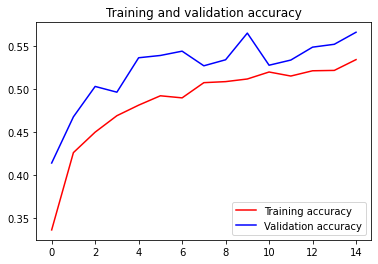

<Figure size 432x288 with 0 Axes>

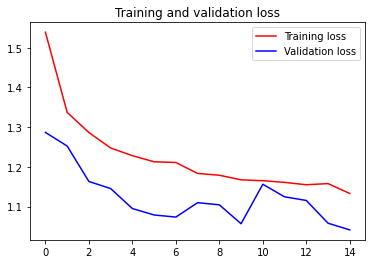

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history_aug_rgb.history['accuracy']
val_acc = history_aug_rgb.history['val_accuracy']
loss = history_aug_rgb.history['loss']
val_loss = history_aug_rgb.history['val_loss']

epochs = range(len(acc))
plot_metrics(acc, val_acc, epochs, "accuracy")
plot_metrics(loss, val_loss, epochs, "loss")

##### VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input


vgg16_model = VGG16(weights='imagenet', include_top=False,  input_shape=(150, 150, 3))

# img_path = 'elephant.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# features = model.predict(x)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# add new classifier layers
flat1 = tf.keras.layers.Flatten()(vgg16_model.layers[-1].output)
class1 = tf.keras.layers.Dense(512, activation='relu')(flat1)
output = tf.keras.layers.Dense(6, activation='softmax')(class1)
# define new model
model_vgg_transfer = tf.keras.Model(inputs=vgg16_model.inputs, outputs=output)
# summarize
model_vgg_transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
model_vgg_transfer.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_vgg_transfer = model_vgg_transfer.fit(
    train_generator,
    epochs=35,
    validation_data=test_generator,
    verbose=2
)

Epoch 1/35
439/439 - 219s - loss: 1.8894 - accuracy: 0.1768 - val_loss: 1.7902 - val_accuracy: 0.1750 - 219s/epoch - 499ms/step
Epoch 2/35
439/439 - 191s - loss: 1.7911 - accuracy: 0.1776 - val_loss: 1.7901 - val_accuracy: 0.1750 - 191s/epoch - 436ms/step
Epoch 3/35
439/439 - 191s - loss: 1.7911 - accuracy: 0.1790 - val_loss: 1.7900 - val_accuracy: 0.1750 - 191s/epoch - 436ms/step
Epoch 4/35
439/439 - 191s - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7900 - val_accuracy: 0.1750 - 191s/epoch - 436ms/step
Epoch 5/35
439/439 - 191s - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7903 - val_accuracy: 0.1750 - 191s/epoch - 436ms/step
Epoch 6/35
439/439 - 191s - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7900 - val_accuracy: 0.1750 - 191s/epoch - 436ms/step
Epoch 7/35
439/439 - 191s - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7901 - val_accuracy: 0.1750 - 191s/epoch - 436ms/step
Epoch 8/35
439/439 - 191s - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7901 - val_accuracy: 0.1750 - 

KeyboardInterrupt: ignored

##### MobileNetV2

In [ ]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = (150, 150, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][